In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import resize
from skimage.transform import radon
import sigpy as sp

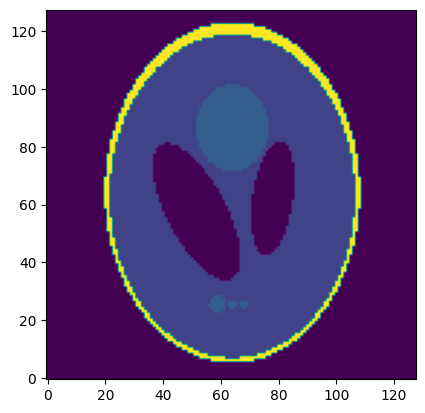

In [2]:
f = sp.shepp_logan((128, 128), dtype='float')
plt.imshow(f, origin= 'lower')

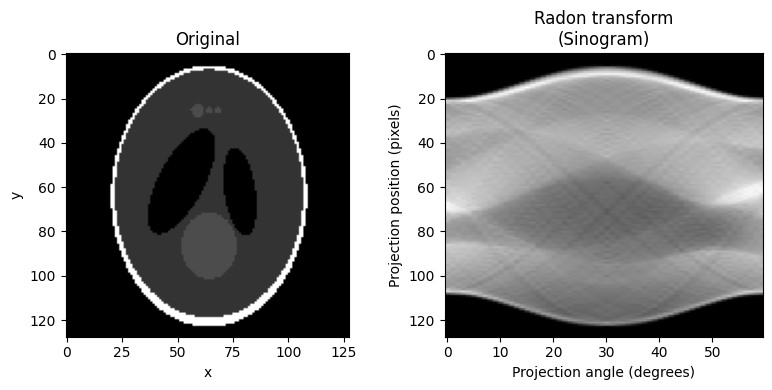

[  0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51
  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 102 105
 108 111 114 117 120 123 126 129 132 135 138 141 144 147 150 153 156 159
 162 165 168 171 174 177]


In [ ]:
# Define the angles for the Radon transform
# For theta = 0, 3, 6, ..., 177
theta = np.arange(0, 180, 3)

# Compute the Radon transform
sinogram = radon(f, theta=theta)

# Display the original image and its sinogram
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].imshow(f, cmap=plt.cm.gray)
ax[0].set_title("Original")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

ax[1].imshow(sinogram, cmap=plt.cm.gray, aspect='auto')
ax[1].set_title("Radon transform\n(Sinogram)")
ax[1].set_xlabel("Projection angle (degrees)")
ax[1].set_ylabel("Projection position (pixels)")

fig.tight_layout()
plt.show()
print(theta)